In [1]:
import pandas as pd
import numpy as np
from NoMASS import NoMASS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_context('talk')
sns.set_style('ticks')

from os.path import expanduser
home = expanduser("~")

### Configuration

In [2]:
# number_of_simulations  = 100 #50 learning 50 simulating
experiment             = '5' #name of experiment
solar_file             = 'PV_single_profile.csv'
tariff                 = 'f1n3' # see database in /basecase/
number_appliances      = 1
name_basecase          = '%iapp_t%s'%(number_appliances, tariff)
name                   = 'exp5_AL' # AL=after learning
description1           =  'Alpha = 0.3; gamma = 0.1, eps = 0.1'
appliance_ids          = [1] #ids of appliances to shift


### NoMAss learning

Have nomass learn for a number of simulations and save the results

In [3]:
nomassLearn = NoMASS()

nomassLearn.runLocation = "../FMU/build/Simulation/"
nomassLearn.locationOfNoMASS = "../FMU/build/"
nomassLearn.configurationDirectory = home +"/git/No-MASSDSM/Configuration/Experiment3/"

nomassLearn.resultsLocation = "../FMU/build/ResultsLearning/"
nomassLearn.PVFile = "PV_single_profile.csv"
nomassLearn.epsilon = 0.1
nomassLearn.alpha = 0.1
nomassLearn.gamma = 0.1
nomassLearn.printInput = True
nomassLearn.pandasFiles = True
nomassLearn.outFiles = False # dont copy Nomas.out
nomassLearn.xmlFiles = False # dont copy simulationcofig.xml
nomassLearn.numberOfSimulations = 300
nomassLearn.learn = True


In [4]:
nomassLearn.deleteLearningData() # clear any previsouly learnt data
nomassLearn.simulate()

Run location: ../FMU/build/Simulation/
locationOfNoMASS: ../FMU/build/
configurationDirectory: /Users/jake/git/No-MASSDSM/Configuration/Experiment3/
resultsLocation: ../FMU/build/ResultsLearning/
printInput: True
numberOfSimulations: 300
Learning: True
Number of agents 2
Number of large appliances 5
Number of small appliances 4
Number of pv appliances 1
Simulation: 1 Time: 01 seconds
Simulation: 26 Time: 26 seconds
Simulation: 51 Time: 52 seconds
Simulation: 76 Time: 77 seconds
Simulation: 101 Time: 103 seconds
Simulation: 126 Time: 129 seconds
Simulation: 151 Time: 155 seconds
Simulation: 176 Time: 185 seconds
Simulation: 201 Time: 215 seconds
Simulation: 226 Time: 249 seconds
Simulation: 251 Time: 284 seconds
Simulation: 276 Time: 319 seconds
Total Simulation Time: 355 seconds


### Read in NoMASS results

If Pandas file were set the results were save as a pandas file so they can be read in fast

In [5]:
ad = nomassLearn.getPandasDF()

In [6]:
ad.TimeStep.dropna().shape[0]/1440.

2100.0

/Users/jake/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jake/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


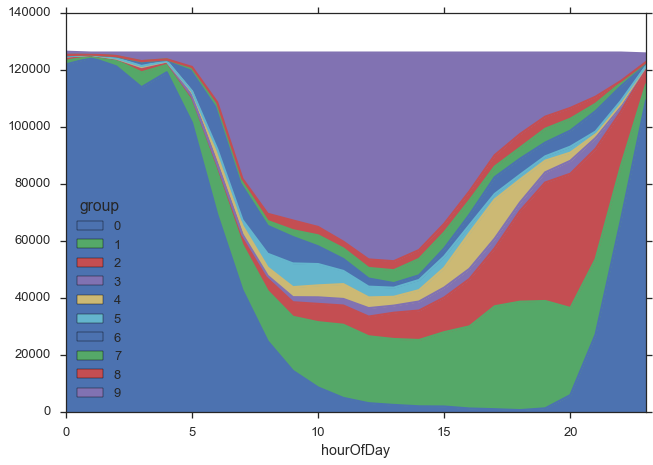

In [7]:
action = ad[[col for col in list(ad) if (col.startswith('Building0_Occupant0') or col.startswith('hour'))]]
list(action.columns.values)
occ = action
occ.loc[:,('group')] = action.loc[:,('Building0_Occupant0_Activity')]
occ = occ.groupby(['hourOfDay', 'group']).count().reset_index()
occ.pivot('hourOfDay', 'group')['Building0_Occupant0_Activity'].plot(kind='area')




In [8]:
action = ad[[col for col in list(ad) if (col.startswith('Building0_Appliance') or col=='nsim')]]

action = action.dropna().reset_index(drop=True)
actions_taken = action.shape[0]
action.shape

(378, 71)

In [9]:
action.ix[:4,['Building0_Appliance1_state',
          'Building0_Appliance1_previous_state',
          'Building0_Appliance1_action',
          'Building0_Appliance1_reward']]


,Building0_Appliance1_state,Building0_Appliance1_previous_state,Building0_Appliance1_action,Building0_Appliance1_reward
0,2.0,11.0,1.0,-11.9276
1,18.0,17.0,17.0,-14.2840
2,8.0,5.0,6.0,-140.4320
3,4.0,2.0,2.0,-10.3415
4,3.0,5.0,3.0,-77.6958


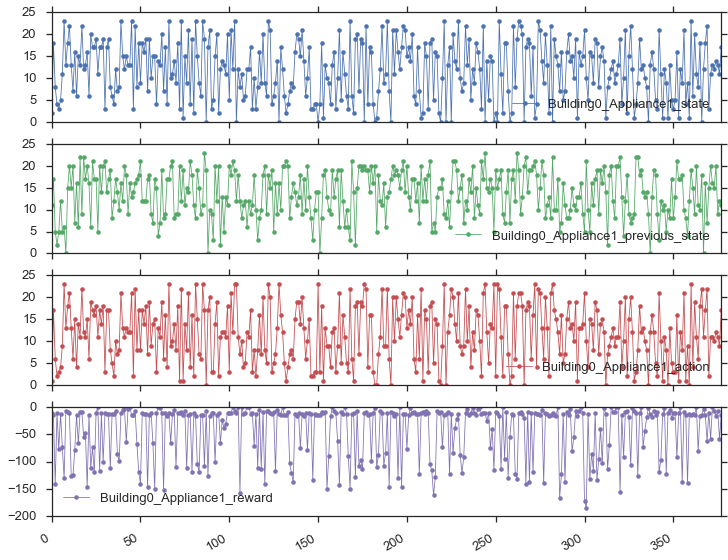

In [10]:
action.ix[:,['Building0_Appliance1_state',
          'Building0_Appliance1_previous_state',
          'Building0_Appliance1_action',
          'Building0_Appliance1_reward']].plot(subplots=True, sharex=True, figsize=(12,10), lw=0.8, style='.-')
figure1 = plt.gcf()

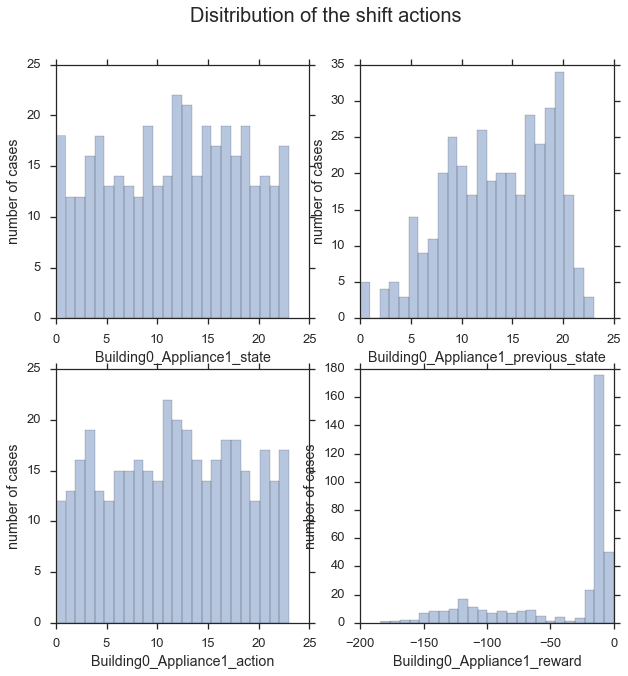

In [11]:
figure11,axn = plt.subplots(2,2,  figsize = (10,10))
for k, col in enumerate(action.ix[:,['Building0_Appliance1_state',
          'Building0_Appliance1_previous_state',
          'Building0_Appliance1_action',
          'Building0_Appliance1_reward']]):
    sns.distplot(action[col],kde=False, bins = 24, ax = axn[k//2,k%2])
    axn[k//2,k%2].set_ylabel('number of cases')
figure11.suptitle('Disitribution of the shift actions',fontsize = 20)

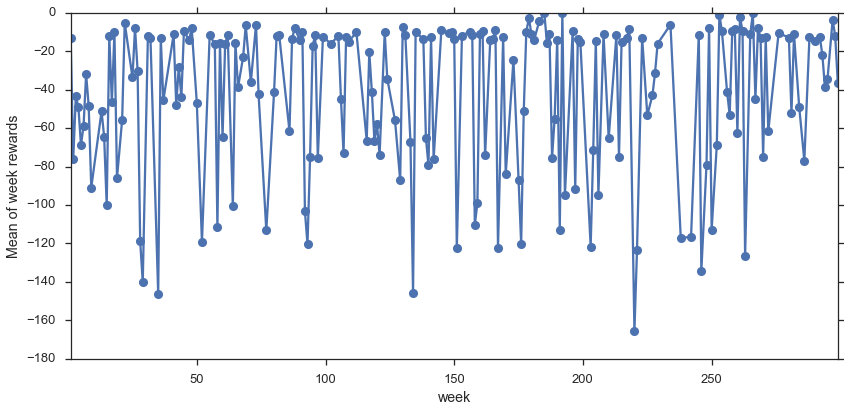

In [12]:
figure2 = plt.figure()
action.groupby('nsim').mean()['Building0_Appliance1_reward'].plot(style = 'o-',figsize=(12,6))
plt.xlabel('week')
plt.ylabel('Mean of week rewards')
plt.tight_layout()

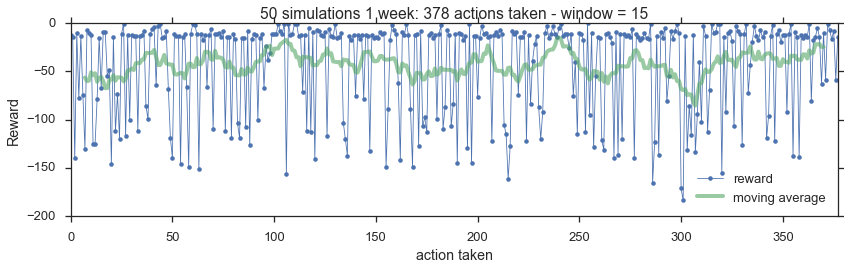

In [13]:
figure3 = plt.figure()
win = 15
action['reward_roll'] = action.Building0_Appliance1_reward.rolling(window=win, center=True).mean()
action['Building0_Appliance1_reward'].plot(lw=0.8,style='.-', figsize = (12,4),label='reward')

action.reward_roll.plot(lw=4., alpha=0.6,label='moving average')
plt.ylabel('Reward')
plt.xlabel('action taken')
plt.legend(loc = 4)
plt.title('50 simulations 1 week: %i actions taken - window = %i'%(actions_taken, win))
plt.tight_layout()

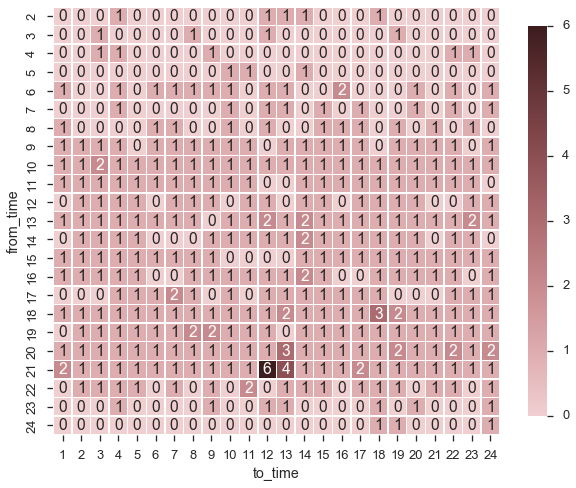

In [14]:
matrix_shifts =action.groupby(by=['Building0_Appliance1_previous_state','Building0_Appliance1_action']).size()

cmap = sns.cubehelix_palette(15, start=0.9, rot=0., as_cmap=True)
matrix_shifts =pd.DataFrame(matrix_shifts.reset_index())
matrix_shifts.columns = ['from_time', 'to_time', 'ntimes']

# sns.set()
figure31 = plt.figure(figsize=(10,10))
matrix_s = matrix_shifts.pivot("from_time", "to_time", "ntimes").fillna(0)

vmin, vmax = matrix_s.values.min(), matrix_s.values.max()
sns.heatmap(matrix_s,  vmin=vmin, vmax=vmax,
            annot = True, linewidths=.5, cbar_kws={"shrink": .7},
            cmap=cmap,square=True,
            xticklabels = range(1,25), yticklabels=range(1,25))

In [15]:
gr = ad.groupby('nsim')
cost_beginning = gr.Building0_Appliance1_cost.sum()[:5].mean()
cost_end = gr.Building0_Appliance1_cost.sum()[-5:].mean()
cost_reduction = (cost_beginning - cost_end)/cost_beginning
cost_reduction * 100

60.98623664799503

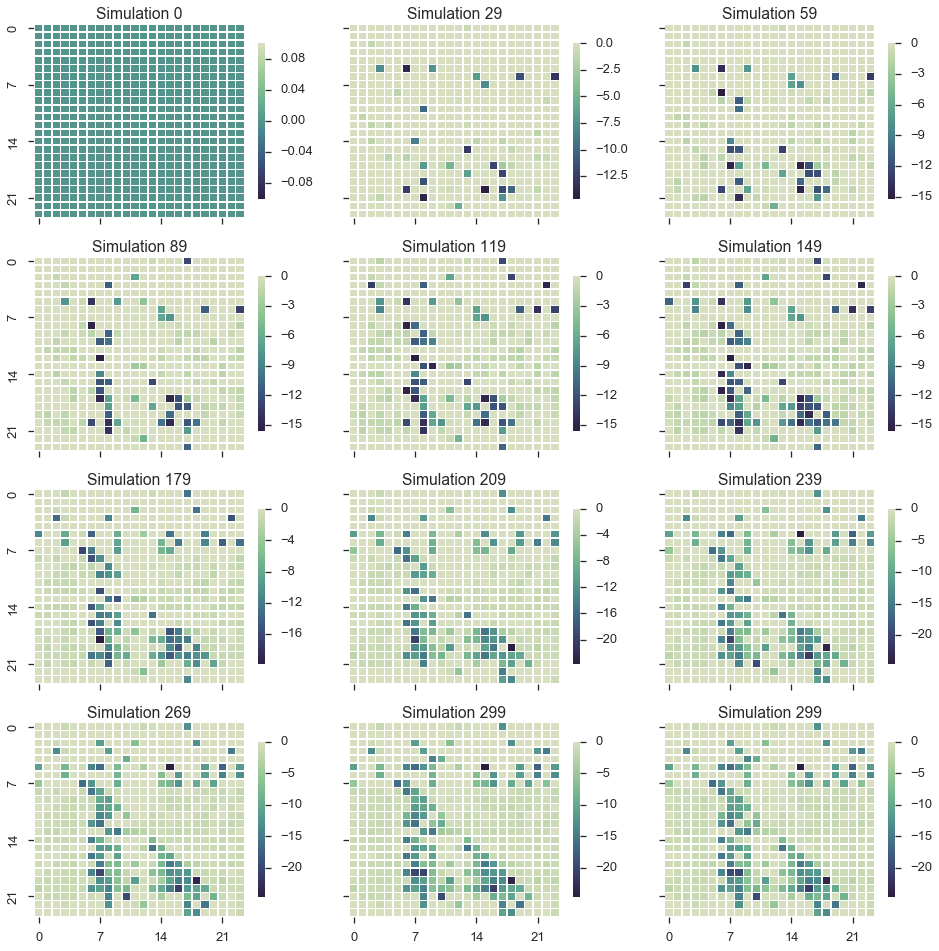

In [16]:
number_of_simulations = nomassLearn.numberOfSimulations -1

cmap = sns.cubehelix_palette(100, start=.5, rot=-.75, as_cmap=True, reverse=True)
how_many_to_plot = 10  #15 or 50
figure5,axn = plt.subplots(how_many_to_plot//3+1, 3, sharex=True, sharey=True,
                       figsize = (16,4*(how_many_to_plot//3 +1)))

for j,ax in enumerate(axn.flat[:number_of_simulations]):
    j=j*number_of_simulations/how_many_to_plot # so that we only take every 3 simulations
    if j < number_of_simulations: pass
    else: j = number_of_simulations
    dat = pd.read_csv(nomassLearn.resultsLocation + '/Building0_Appliance1_1.dat.%.5i'%j,header=None,usecols=range(24))
    vmaj = dat.values.min()
    sns.heatmap(dat, cmap=cmap, square=False, xticklabels=7, yticklabels=7,
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax,vmin=vmaj)
    ax.set_title('Simulation %i'%j)
#     vmin= dat.values.min()
    if j==number_of_simulations : vmaj = dat.values.min()
# vmaj = vmin

### Have Nomass simulate a base case data

Simulate a base case for comparison

In [17]:
basecase = NoMASS()
basecase.runLocation = "../FMU/build/Simulation/"
basecase.locationOfNoMASS = "../FMU/build/"
basecase.configurationDirectory = home +"/git/No-MASSDSM/Configuration/Experiment4/"

basecase.resultsLocation = "../FMU/build/ResultsBaseCase/"
basecase.PVFile = "PV_single_profile.csv"
basecase.printInput = True
basecase.pandasFiles = True
basecase.outFiles = False # dont copy Nomas.out
basecase.xmlFiles = False # dont copy simulationcofig.xml
basecase.numberOfSimulations = 100

In [18]:
basecase.simulate()

Run location: ../FMU/build/Simulation/
locationOfNoMASS: ../FMU/build/
configurationDirectory: /Users/jake/git/No-MASSDSM/Configuration/Experiment4/
resultsLocation: ../FMU/build/ResultsBaseCase/
printInput: True
numberOfSimulations: 100
Learning: False
Number of agents 2
Number of large appliances 6
Number of small appliances 4
Number of pv appliances 1
Simulation: 1 Time: 01 seconds
Simulation: 26 Time: 26 seconds
Simulation: 51 Time: 52 seconds
Simulation: 76 Time: 78 seconds
Total Simulation Time: 103 seconds


In [19]:
# Weekly dataframe:
basecase_ad = basecase.getPandasDF()
# print basecase_ad.TimeStep.dropna().shape[0]/1440.

In [20]:
# COST 
basecase_df = pd.DataFrame([])
for idapp in appliance_ids:  # appliances ID
    weekly_cost = basecase_ad.groupby(by='nsim')['Building0_Appliance%i_cost'%idapp].sum()
    weekly_poweruse = basecase_ad.groupby(by='nsim')['Building0_Appliance%i_recieved'%idapp].sum()
    basecase_df['cost_%i'%idapp]    = weekly_cost
    basecase_df['poweruse_%i'%idapp]= weekly_poweruse
#AND SELF CONSUMPTIOn
dif = basecase_ad.Building0_Appliance10_supplied  -  basecase_ad.Building0_Appliance_Sum_Recieved
basecase_ad['gridImport'] = dif.where(dif<0,0)
basecase_ad['pvExport'] = dif.where(dif>0,0)
basecase_ad['pvUse'] = basecase_ad.Building0_Appliance10_supplied - basecase_ad['pvExport'] 
# # totals
grouped = basecase_ad.groupby('nsim')
weekly_demand = grouped.Building0_Appliance_Sum_Recieved.sum()
weekly_pv     = grouped.Building0_Appliance10_supplied.sum()
weekly_grid   = grouped.gridImport.sum()
weekly_pvexp  = grouped.pvExport.sum()
weekly_pvuse  = grouped.pvUse.sum()

self_consumption_index = weekly_pvuse/weekly_demand *100
self_consumption_potential = weekly_pv/weekly_demand *100
basecase_df['self_cons_index'] = self_consumption_index
basecase_df['self_cons_potential'] = self_consumption_potential

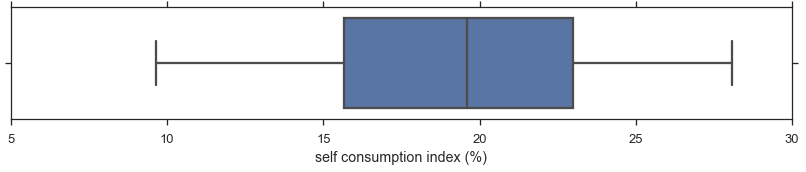

In [21]:
fig2 = plt.figure(figsize = (14,2))
sns.boxplot(basecase_df.self_cons_index, orient = 'h')
plt.xlabel('self consumption index (%)')
# sns.boxplot(self_consumption_index)

### Have Nomass simulate useing the learnt data

Using the learnt data simulate some resutls for comparison
set epsilon to 0 so no randomness takes place
set learn to false so no longer updates the learning q-table
set learntData to the location of the learnt values

In [22]:
nomass = NoMASS()
nomass.runLocation = "../FMU/build/Simulation/"
nomass.locationOfNoMASS = "../FMU/build/"
nomass.configurationDirectory = home +"/git/No-MASSDSM/Configuration/Experiment3/"

nomass.resultsLocation = "../FMU/build/ResultsLearnt/"
nomass.PVFile = "PV_single_profile.csv"
nomass.printInput = True
nomass.pandasFiles = True
nomass.outFiles = False # dont copy Nomas.out
nomass.xmlFiles = False # dont copy simulationcofig.xml
nomass.numberOfSimulations = 100
nomass.epsilon = 0.0
nomass.learn = False
nomass.learntData = nomassLearn.learntDataLocation()

In [23]:
nomass.simulate()

Run location: ../FMU/build/Simulation/
locationOfNoMASS: ../FMU/build/
configurationDirectory: /Users/jake/git/No-MASSDSM/Configuration/Experiment3/
resultsLocation: ../FMU/build/ResultsLearnt/
printInput: True
numberOfSimulations: 100
Learning: False
Number of agents 2
Number of large appliances 5
Number of small appliances 4
Number of pv appliances 1
Simulation: 1 Time: 01 seconds
Simulation: 26 Time: 27 seconds
Simulation: 51 Time: 53 seconds
Simulation: 76 Time: 79 seconds
Total Simulation Time: 104 seconds


In [24]:
ad = nomass.getPandasDF()
ad_AL = ad[['Building0_Appliance1_requested',
          'Building0_Appliance1_recieved',
          'Building0_Appliance1_cost',
          'Building0_Appliance1_suppliedCost',
            'Building0_Appliance10_supplied',
          'nsim']]
print ad.TimeStep.dropna().shape[0]/1440.

700.0


In [25]:
weekly_df_AL = pd.DataFrame([])
for idapp in appliance_ids:  # appliances ID
    weekly_cost = ad_AL.groupby(by='nsim')['Building0_Appliance%i_cost'%idapp].sum()
    weekly_poweruse = ad_AL.groupby(by='nsim')['Building0_Appliance%i_recieved'%idapp].sum()
    weekly_df_AL['cost_%i'%idapp]    = weekly_cost
    weekly_df_AL['poweruse_%i'%idapp]= weekly_poweruse
    
#self consumption
dif = ad.Building0_Appliance10_supplied  -  ad.Building0_Appliance_Sum_Recieved
ad['gridImport'] = dif.where(dif<0,0)
ad['pvExport'] = dif.where(dif>0,0)
ad['pvUse'] = ad.Building0_Appliance10_supplied - ad['pvExport'] 
# totals
grouped = ad.groupby('nsim')
weekly_demand = grouped.Building0_Appliance_Sum_Recieved.sum()
weekly_pv     = grouped.Building0_Appliance10_supplied.sum()
weekly_grid   = grouped.gridImport.sum()
weekly_pvexp  = grouped.pvExport.sum()
weekly_pvuse  = grouped.pvUse.sum()
weekly_df_AL['self_cons_index'] =     weekly_pvuse/weekly_demand  * 100
weekly_df_AL['self_cons_potential'] = weekly_pv/weekly_demand     * 100



/Users/jake/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


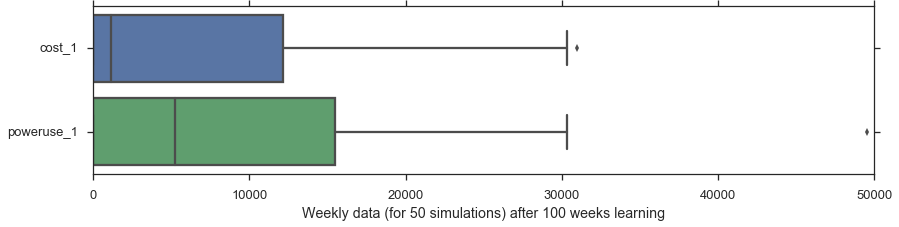

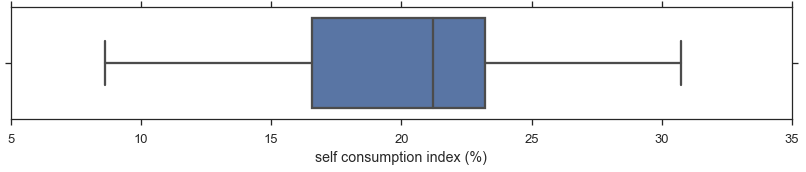

In [26]:
fig1=plt.figure(figsize = (14,3))
sns.boxplot(weekly_df_AL.ix[:,0:2], orient = 'h')
plt.xlabel('Weekly data (for 50 simulations) after 100 weeks learning')
fig2 = plt.figure(figsize = (14,2))
sns.boxplot(weekly_df_AL.self_cons_index, orient = 'h')
plt.xlabel('self consumption index (%)')

## Comparison: basecase_df - weekly_df_AL (after learning)

In [27]:
cost_df               = pd.melt(weekly_df_AL,
                                value_vars=['cost_1','cost_4'], 
                                value_name = 'cost', 
                                var_name = 'id')
cost_df_basecase      = pd.melt(basecase_df,
                                value_vars=['cost_1','cost_4'], 
                                value_name = 'cost', 
                                var_name = 'id')
poweruse_df           = pd.melt(weekly_df_AL,
                                value_vars=['poweruse_1','poweruse_4'], 
                                value_name = 'poweruse', 
                                var_name = 'id')
poweruse_df_basecase = pd.melt(basecase_df,
                               value_vars=['poweruse_1','poweruse_4'], 
                               value_name = 'poweruse', 
                               var_name = 'id')

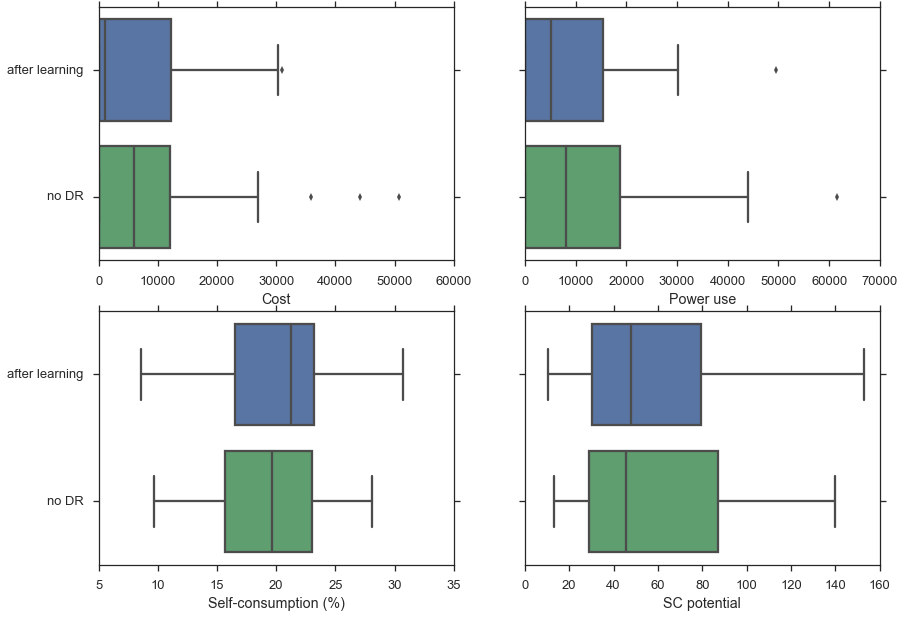

In [28]:
fig3,axn = plt.subplots(2,2,figsize = (14,10),sharey=True)

cost = pd.concat([cost_df,cost_df_basecase], keys = ['after learning','no DR'])
cost.reset_index(level=0,inplace=True)
pu = pd.concat([poweruse_df,poweruse_df_basecase], keys = ['after learning','no DR'])
pu.reset_index(level=0,inplace=True)

sc = pd.DataFrame({'no DR': basecase_df.self_cons_index, 'after learning': weekly_df_AL.self_cons_index})
potential = pd.DataFrame({'no DR': basecase_df.self_cons_potential, 
                            'after learning': weekly_df_AL.self_cons_potential})
sns.boxplot(y="level_0",x='cost', data = cost,  orient = 'h',ax= axn[0,0]) #hue='id',  uncomment for 2 shift appliances
sns.boxplot(y="level_0",x='poweruse', data = pu, orient = 'h',ax= axn[0,1]) #hue='id', 
sns.boxplot(sc, orient = 'h', ax= axn[1,0])
sns.boxplot(potential, orient = 'h', ax= axn[1,1])

axn[0,0].set_xlabel('Cost')
axn[0,0].set_ylabel(' ')
axn[0,1].set_xlabel('Power use')
axn[0,1].set_ylabel(' ')
axn[1,0].set_xlabel('Self-consumption (%)')
axn[1,1].set_xlabel('SC potential')

In [29]:
sc_base = basecase_df.self_cons_index.mean()
sc_AL = weekly_df_AL.self_cons_index.mean()
sc_percent = (sc_AL - sc_base)/sc_base * 100
sc_percent

2.1165179497416737

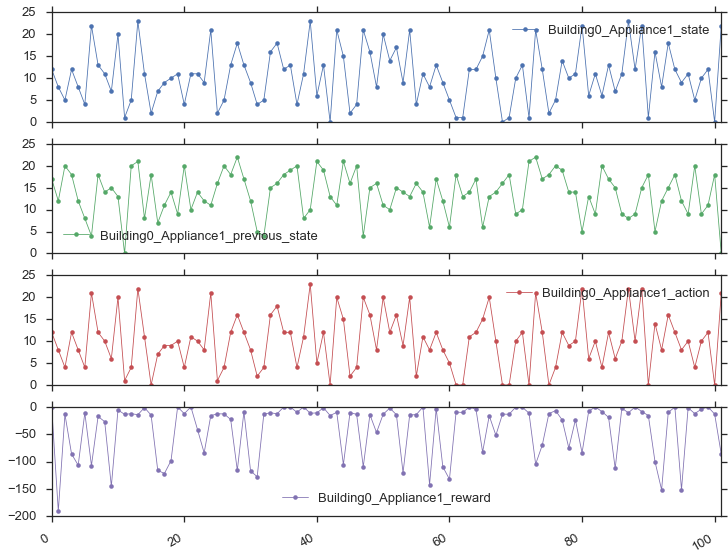

In [30]:
action = ad[[col for col in list(ad) if (col.startswith('Building0_Appliance') or col=='nsim')]]

action = action.dropna().reset_index(drop=True)
actions_taken = action.shape[0]

action.ix[:,['Building0_Appliance1_state',
          'Building0_Appliance1_previous_state',
          'Building0_Appliance1_action',
          'Building0_Appliance1_reward']].plot(subplots=True, sharex=True, figsize=(12,10), lw=0.8, style='.-')
figure1 = plt.gcf()

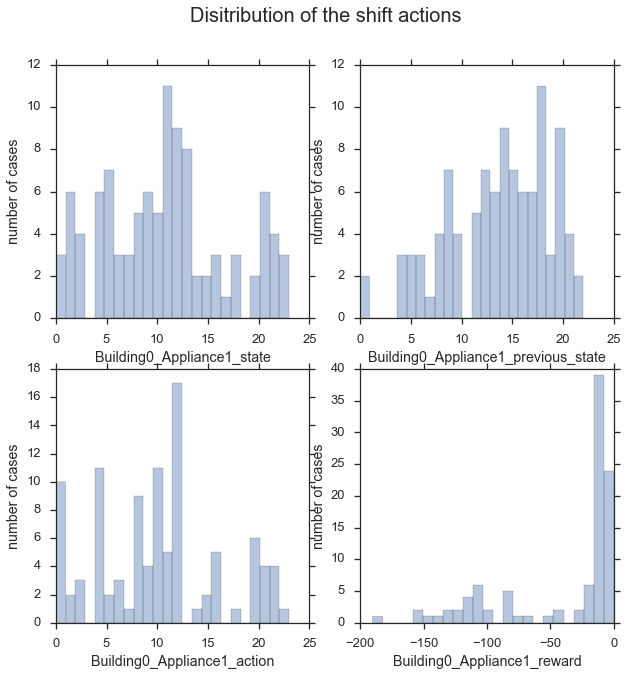

In [31]:
figure11,axn = plt.subplots(2,2,  figsize = (10,10))
for k, col in enumerate(action.ix[:,['Building0_Appliance1_state',
          'Building0_Appliance1_previous_state',
          'Building0_Appliance1_action',
          'Building0_Appliance1_reward']]):
    sns.distplot(action[col],kde=False, bins = 24, ax = axn[k//2,k%2])
    axn[k//2,k%2].set_ylabel('number of cases')
figure11.suptitle('Disitribution of the shift actions',fontsize = 20)

In [32]:

basecase_ad_nodr = basecase_ad[['Building0_Appliance1_requested',
          'Building0_Appliance1_recieved',
          'Building0_Appliance1_cost',
          'Building0_Appliance1_suppliedCost',
          'nsim']]

weekly_cost = ad_AL.groupby(by='nsim').Building0_Appliance1_cost.sum()
weekly_poweruse = ad_AL.groupby(by='nsim').Building0_Appliance1_recieved.sum()
weekly_cost_b = basecase_ad_nodr.groupby(by='nsim').Building0_Appliance1_cost.sum()
weekly_poweruse_b = basecase_ad_nodr.groupby(by='nsim').Building0_Appliance1_recieved.sum()

weekly_df = pd.DataFrame({'Learnt Cost': weekly_cost, 'Base Cost': weekly_cost_b, 'Learnt Power': weekly_poweruse, 'Base Power': weekly_poweruse_b})


print('Cost for 1 Appliance learnt: %d'%(np.median(weekly_cost)))
print('Cost for 1 Appliance basecase: %d'%(np.median(weekly_cost_b)))
print('Saving: %d'%(np.median(weekly_cost_b) - np.median(weekly_cost)))


Cost for 1 Appliance learnt: 1118
Cost for 1 Appliance basecase: 5997
Saving: 4879


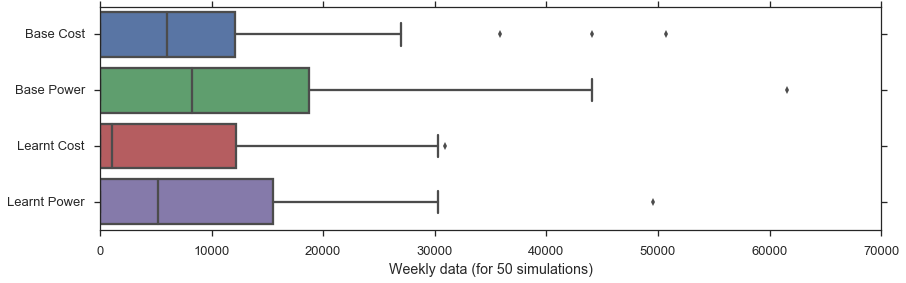

In [33]:
fig1=plt.figure(figsize = (14,4))
sns.boxplot(data=weekly_df, orient = 'h')
plt.xlabel('Weekly data (for 50 simulations)')


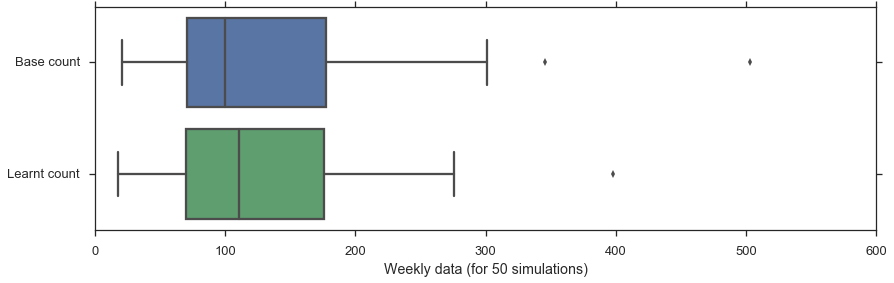

In [34]:
weekly_count = ad[ad.Building0_Appliance1_recieved > 0].groupby(by='nsim').Building0_Appliance1_recieved.count()
weekly_count_b = basecase_ad[basecase_ad.Building0_Appliance1_recieved > 0].groupby(by='nsim').Building0_Appliance1_recieved.count()

weekly_df_count = pd.DataFrame({'Learnt count': weekly_count, 'Base count': weekly_count_b})


fig1=plt.figure(figsize = (14,4))
sns.boxplot(data=weekly_df_count, orient = 'h')
plt.xlabel('Weekly data (for 50 simulations)')

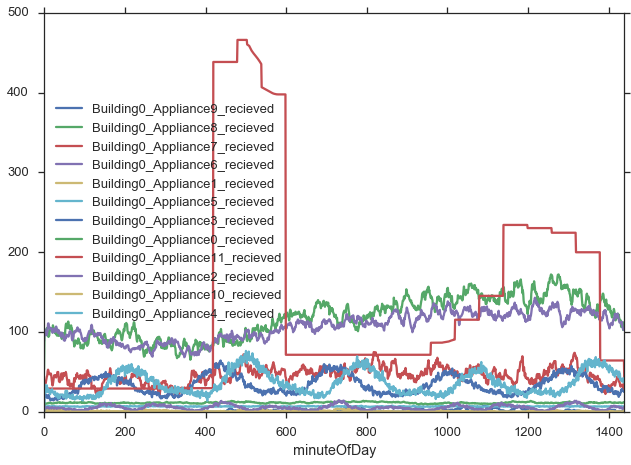

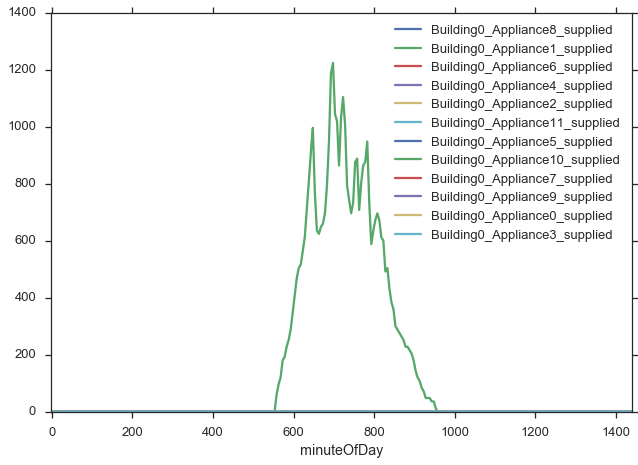

In [53]:

appliances_recieved = ad[[col for col in list(ad) if (col.endswith('recieved') or col=='minuteOfDay')]]
appliances_supply = ad[[col for col in list(ad) if (col.endswith('supplied') or col=='minuteOfDay')]]
appliances_cost = ad[[col for col in list(ad) if (col.endswith('cost') or col=='minuteOfDay')]]
appliances_shift = ad[[col for col in list(ad) if (col.startswith('Building0_Appliance1_recieved') or col=='minuteOfDay')]]

appliances_recieved.groupby('minuteOfDay').mean().plot()
appliances_supply.groupby('minuteOfDay').mean().plot()

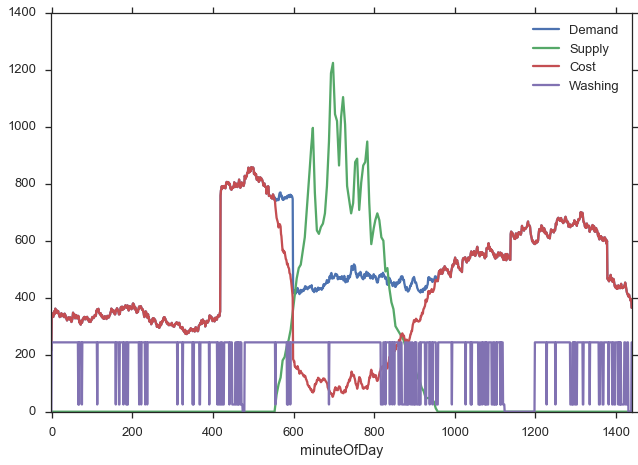

In [55]:
total =  pd.DataFrame()
total['Demand'] = appliances_recieved.groupby('minuteOfDay').mean().sum(axis=1)
total['Supply'] = appliances_supply.groupby('minuteOfDay').mean().sum(axis=1)
total['Cost'] = appliances_cost.groupby('minuteOfDay').mean().sum(axis=1)
total['Washing'] = appliances_shift.groupby('minuteOfDay').max().sum(axis=1)
total.plot()

In [52]:
ad.columns.values

array(['stepCount', 'Building0_Appliance_Sum_fmi',
       'Building0_Appliance9_cost', 'Building0_Appliance9_suppliedCost',
       'Building0_Appliance9_recieved', 'Building0_Appliance8_cost',
       'Building0_Appliance8_recieved',
       'Building0_Appliance8_suppliedCost',
       'Building0_Appliance8_supplied', 'Building0_Appliance7_recieved',
       'Building0_Appliance6_requested', 'Building0_Appliance6_recieved',
       'Building0_Appliance6_suppliedCost',
       'Building0_Appliance1_requested', 'Building0_Appliance0_cost',
       'Building0_Appliance1_recieved', 'Building0_Appliance1_action',
       'Building0_Appliance1_suppliedCost',
       'Building0_Appliance1_supplied', 'Building0_Appliance4_cost',
       'Building0_Appliance5_suppliedCost', 'Building0_Appliance1_state',
       'Building0_Appliance1_reward', 'Building0_Appliance10_cost',
       'Building0_Appliance1_actual', 'Building0_Appliance5_cost',
       'Block1:KitchenAverageGains', 'Building0_Appliance5_recieved',